In [1]:
import sys
sys.path.append('../../src')

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVC

from imblearn.over_sampling import ADASYN, SMOTE

import visualization.visualize as vis
import models.evaluation as ev

In [2]:
filename = '../../data/raw/Myocardial infarction complications Database.csv'
data = pd.read_csv(filename)
data

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1696,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,...,0,0,1,0,1,0,0,0,0,3
1696,1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1697,1698,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6
1698,1699,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1


# Data Preparation

In [3]:
ID_COLS = ['ID']
TARGET_COLS = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS']
TARGET_COL = 'LET_IS'

In [4]:
FEATURE_COLS = np.array(data.columns[~np.isin(data.columns, ID_COLS+TARGET_COLS)])
FEATURE_COLS

array(['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST',
       'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11',
       'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01',
       'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01',
       'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03',
       'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG',
       'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST',
       'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im',
       'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02',
       'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08',
       'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04',
       'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09',
       'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04',
       'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08',
       'n_p

In [5]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

print('data_train:', data_train.shape)
print('data_test:', data_test.shape)

data_train: (1190, 124)
data_test: (510, 124)


In [6]:
data_train[TARGET_COL].value_counts(dropna=False)

0    1003
1      76
3      38
6      20
7      16
2      15
4      14
5       8
Name: LET_IS, dtype: int64

In [7]:
data_test[TARGET_COL].value_counts(dropna=False)

0    426
1     34
3     16
7     11
4      9
6      7
5      4
2      3
Name: LET_IS, dtype: int64

In [8]:
data_train[TARGET_COL][data_train[TARGET_COL] > 0] = 1
data_test[TARGET_COL][data_test[TARGET_COL] > 0] = 1

<ipython-input-8-3416135e8b55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[TARGET_COL][data_train[TARGET_COL] > 0] = 1
c:\users\weldl\miniconda3\envs\work\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-8-3416135e8b55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test[TARGET_COL][data_test[TARGET_COL] > 0] = 1
c:\us

In [9]:
data_train[TARGET_COL].value_counts(dropna=False)

0    1003
1     187
Name: LET_IS, dtype: int64

In [10]:
data_test[TARGET_COL].value_counts(dropna=False)

0    426
1     84
Name: LET_IS, dtype: int64

In [11]:
def data_preparation(x_df, y_cols, target_col):
    x_array = x_df.drop(columns=y_cols)
    y_true = x_df[target_col].values
    return x_array, y_true

x_train, y_train = data_preparation(data_train, TARGET_COLS+ID_COLS, TARGET_COL)
x_test, y_test = data_preparation(data_test, TARGET_COLS+ID_COLS, TARGET_COL)

In [12]:
x_train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1133,48.0,1,2.0,6.0,2.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
900,59.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
682,78.0,0,1.0,4.0,2.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
767,64.0,1,0.0,2.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
177,68.0,0,0.0,5.0,2.0,2.0,NaN,2.0,0.0,5.0,...,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,73.0,1,0.0,3.0,2.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1294,63.0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
860,58.0,1,2.0,4.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1459,64.0,0,1.0,1.0,2.0,2.0,NaN,2.0,0.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [13]:
y_train

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [14]:
x_test

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1492,67.0,0,1.0,0.0,0.0,2.0,NaN,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
115,59.0,0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
135,58.0,1,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
352,61.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,7.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1302,77.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,62.0,1,0.0,4.0,2.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
471,43.0,1,1.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
322,69.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1235,80.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [15]:
y_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

# Pre-processing

In [16]:
numeric_cols = ['AGE', 'INF_ANAM', 'STENOK_AN', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT',
                'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE',
                'R_AB_1_n', 'NA_R_1_n', 'NOT_NA_1_n',
               ]
boolean_cols = ['SEX', 'IBS_NASL', 'SIM_GIPERT',
                'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04',  'nr_07', 'nr_08',
                'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10',
                'endocr_01', 'endocr_02', 'endocr_03',
                'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06',
                'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P',
                'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08',
                'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09',
                'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08',
                'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12',
                'fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08',
                'GIPO_K', 'GIPER_NA', 'NA_KB', 'NOT_NA_KB', 'LID_KB', 'NITR_S',
                'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n',
               ]
categoric_cols = ['FK_STENOK', 'IBS_POST', 'ZSN_A', 'ant_im', 'lat_im', 'inf_im', 'post_im',
                 ]
ordinal_cols = ['GB', 'DLIT_AG', 'TIME_B_S', 
               ]

print(len(numeric_cols+boolean_cols+categoric_cols+ordinal_cols), 'features selected')

105 features selected


In [17]:
# SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
# Features encoding:
features_encoder = ColumnTransformer([
                                      ("numeric cols", Pipeline([('num imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
                                                                 ('num scaling', MinMaxScaler()),
                                                                ]), numeric_cols),
                                      ("boolean cols", Pipeline([('bool imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
                                                                ]), boolean_cols),
                                      ("categoric cols", Pipeline([('cat imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
                                                                   ('cat one-hot encoder', OneHotEncoder(handle_unknown='ignore')),
                                                                ]), categoric_cols),
                                      ("ordinal cols", Pipeline([('ord imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
                                                                 ('ord one-hot encoder', OneHotEncoder(handle_unknown='ignore')),
                                                                ]), ordinal_cols),
                                     ], remainder='drop')

In [18]:
# Features creation;
features_creator = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [19]:
# features_selector = VarianceThreshold(threshold=0.02)
# features_selector = SelectFromModel(estimator=LogisticRegression())
# features_selector = SelectFromModel(estimator=RandomForestClassifier(), threshold="5*mean")
features_selector = SelectFromModel(estimator=RandomForestClassifier())

In [20]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', features_encoder),
#                          ('features creation', features_creator),
                         ('features selection', features_selector),
                         ])

In [21]:
x_train_encoded = preprocessor.fit_transform(x_train, y_train)
pd.DataFrame(x_train_encoded)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.526882,0.75,1.000000,0.000000,0.000000,0.425287,0.574468,0.600000,0.800000,0.3250,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.645161,0.25,1.000000,0.655172,0.528796,0.501916,0.645390,0.000000,0.000000,0.3250,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.849462,0.50,0.714286,0.501916,0.424084,0.425287,0.503546,0.000000,0.000000,0.0000,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.698925,0.25,0.428571,0.000000,0.000000,0.463602,0.574468,0.488889,0.817647,0.3625,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.741935,0.25,0.857143,0.000000,0.000000,0.501916,0.574468,0.533333,0.770588,0.2875,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0.795699,0.25,0.571429,0.000000,0.000000,0.463602,0.574468,0.000000,0.000000,0.3250,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1186,0.688172,0.25,0.142857,0.578544,0.476440,0.425287,0.503546,0.466667,0.752941,0.5900,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1187,0.634409,0.75,0.714286,0.000000,0.000000,0.501916,0.574468,0.600000,0.800000,0.0000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1188,0.698925,0.50,0.285714,0.425287,0.371728,0.425287,0.503546,0.644444,0.788235,0.3450,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
x_test_encoded = preprocessor.transform(x_test)
pd.DataFrame(x_test_encoded)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.731183,0.50,0.142857,0.655172,0.528796,0.501916,0.645390,0.633333,0.788235,0.3250,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.645161,0.25,0.142857,0.000000,0.000000,0.000000,0.000000,0.600000,0.805882,0.3250,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.634409,0.25,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.666667,0.25,0.142857,0.000000,0.000000,0.386973,0.503546,0.000000,0.000000,0.0000,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.838710,0.25,0.142857,0.000000,0.000000,0.540230,0.645390,0.511111,0.817647,0.3450,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.677419,0.25,0.714286,0.000000,0.000000,0.425287,0.503546,0.566667,0.805882,0.6600,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
506,0.473118,0.50,0.142857,0.000000,0.000000,0.463602,0.574468,0.000000,0.000000,0.0000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
507,0.752688,0.25,0.142857,0.000000,0.000000,0.540230,0.645390,0.500000,0.823529,0.3250,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
508,0.870968,0.25,0.142857,0.348659,0.319372,0.386973,0.432624,0.544444,0.829412,0.3450,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Plottting Embeddings:

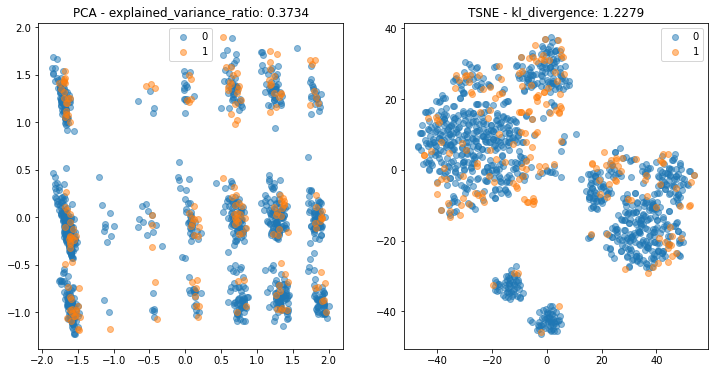

In [23]:
vis.plot_embeddings(x_train_encoded, y_train)

# Dealing with the imbalance

In [24]:
print('Original train dataset  classes distribution:', Counter(y_train))

sm = SMOTE(random_state=42, k_neighbors=5)
x_train_encoded, y_train = sm.fit_resample(x_train_encoded, y_train)
# ada = ADASYN(random_state=42, n_neighbors=5)
# x_train_encoded, y_train = ada.fit_resample(x_train_encoded, y_train)

print('Resampled train dataset classes distribution:', Counter(y_train))

Original train dataset  classes distribution: Counter({0: 1003, 1: 187})
Resampled train dataset classes distribution: Counter({0: 1003, 1: 1003})


In [25]:
print('Original test dataset classes distribution:', Counter(y_test))

Original test dataset classes distribution: Counter({0: 426, 1: 84})


# Plottting Embeddings (after re-balancing):

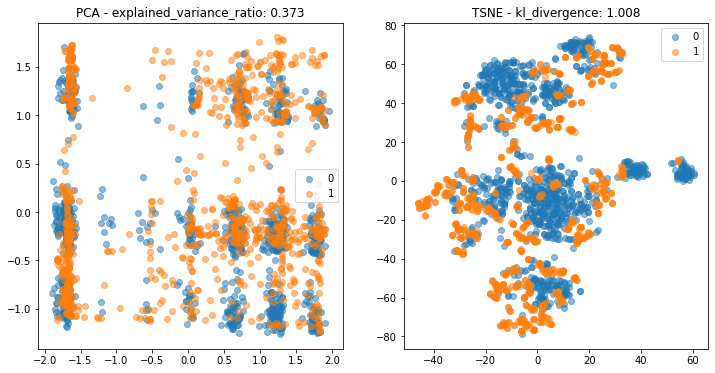

In [26]:
vis.plot_embeddings(x_train_encoded, y_train)

# Training a basic model

In [27]:
n_jobs = 4

In [28]:
# Random Forest:
param_grid = {'bootstrap': [False, True],
              'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [10, 50, 100, 200, 300, 500]}

rf_clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=100, cv=10,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
rf_clf.fit(x_train_encoded, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500]},
                   scoring='balanced_accuracy', verbose=1)

In [29]:
# Logistic Regression:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100,800,100)),
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }

lr_clf = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, n_iter=100, cv=10,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
lr_clf.fit(x_train_encoded, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.85293564        nan        nan 0.77366832 0.80759901
 0.85043069 0.85393069 0.85043069        nan 0.5               nan
 0.85192079 0.84794059 0.77366832 0.85043069 0.84943069 0.84994059
 0.85192079 0.5        0.85192079 0.77366832 0.84994059 0.83600495
 0.85093069        nan 0.85393069        nan        nan 0.85393069
 0.83600495 0.80759901 0.85043069 0.85043069        nan 0.85043069
 0.85043069        nan        nan 0.76819307        nan        nan
 0.85043069        nan 0.80759406        nan 0.80759406 0.77367327
 0.85192079 0.80759406 0.85192079        nan 0.85093069 0.76819307
 0.85293564 0.76819307 0.8290198  0.85393069 0.84993069 0.8205396
 0.85043069 0.85093069 0.80759901        nan 0.85393069        nan
 0.77366832        nan 0.83050495 0.84893069        nan 0.66789109
 0.85192079 0.85043069 0.85192079 0.8360049

RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_iter=100, n_jobs=4,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='balanced_accuracy', verbose=1)

In [30]:
# KNN:
param_grid={'n_neighbors': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'metric': ['minkowski', 'euclidean', 'manhattan'],
           }

knn_clf = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid, n_iter=100, cv=10,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
knn_clf.fit(x_train_encoded, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'weights': ['uniform', 'distance']},
                   scoring='balanced_accuracy', verbose=1)

In [31]:
# # SVM:
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'degree': [1, 2, 3, 4, 5],
#              }

# svm_clf = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=50,
#                              scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
# svm_clf.fit(x_train_encoded, y_train)

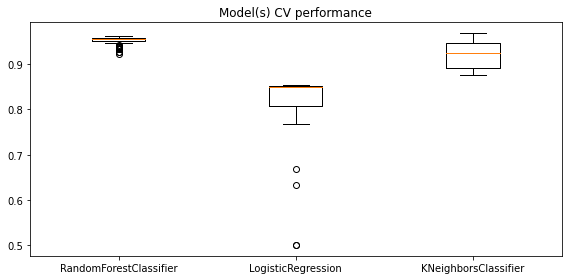

In [32]:
estimators_list = [rf_clf, lr_clf, knn_clf]
ev.plot_estimators_cvperf(estimators_list)

In [33]:
model = estimators_list[np.argmax([pd.DataFrame(m.cv_results_)['mean_test_score'].dropna().mean() for m in estimators_list])].best_estimator_
model.fit(x_train_encoded, y_train)

RandomForestClassifier(bootstrap=False, max_depth=100, max_features=3,
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)

# Evaluating the model:

Classes evaluated: ['0', '1']
Correctly classified......: 452/510
Accuracy (simple) ........: 0.89
Balanced acc.  ...........: 0.68
Balanced acc. (adjusted)..: 0.37
Precision = tp / (tp + fp): [0.89 0.84] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.99 0.38] -> sensibility (true positive rate)
F1 score .................: [0.94 0.52] -> harmonic mean


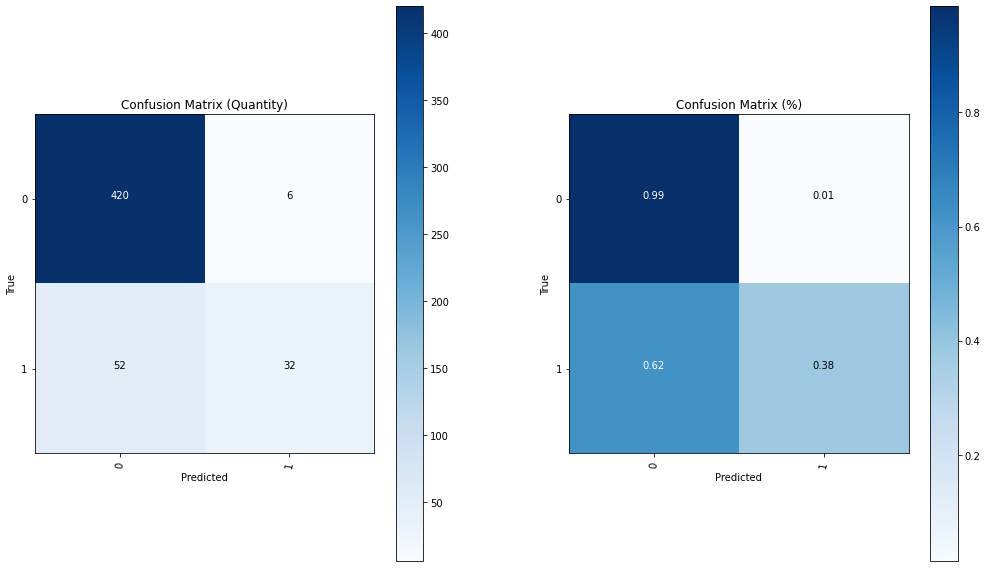

In [34]:
y_pred = model.predict(x_test_encoded)
test_metrics = ev.performance_measures(y_test, y_pred)

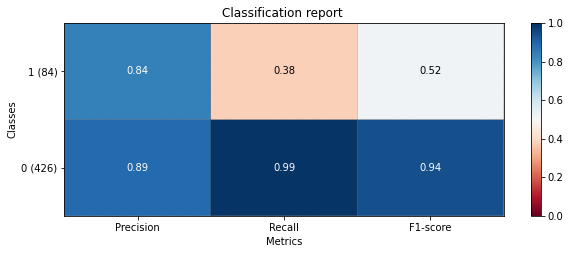

In [35]:
ev.plot_classification_report(y_test, y_pred)